### Compony Bankeuptcy Prediction by Using Machine Learning model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

In [ ]:
data = pd.read_csv('drive/MyDrive/Datasets/bankeuptcy.csv')
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,continuous interest rate (after tax),operating expense rate,research and development expense rate,cash flow rate,interest-bearing debt interest rate,tax rate (A),per Net Share Value (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan),Operating Profit Per Share (Yuan),Per Share Net profit before tax (yuan),realized sales gross profit growth rate,operating profit growth rate,after-tax net profit growth rate,regular net profit growth rate,continuous net profit growth rate,total asset growth rate,net value growth rate,total asset return growth rate Ratio,cash reinvestment %,current ratio,quick ratio,interest expense ratio,total debt/total net worth,debt ratio %,net worth/assets,long-term fund suitability ratio (A),...,current assets/total assets,cash / total assets,Quick asset /current liabilities,cash / current liability,current liability to assets,operating funds to liability,Inventory/working capital,Inventory/current liability,current liability / liability,working capital/equity,current liability/equity,long-term liability to current assets,Retained Earnings/Total assets,total income / total expense,total expense /assets,current asset turnover rate,quick asset turnover rate,working capitcal turnover rate,cash turnover rate,Cash flow to Sales,fix assets to assets,current liability to liability,current liability to equity,equity to long-term liability,Cash flow to total assets,cash flow to liability,CFO to ASSETS,cash flow to equity,current liabilities to current assets,one if total liabilities exceeds total assets zero otherwise,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Bankrupt?                                                            6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest             6819 non-null   float64
 2    ROA(A) before interest and % after tax                              6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax                   6819 non-null   float64
 4    operating gross margin                                              6819 non-null   float64
 5    realized sales gross margin                                         6819 non-null   float64
 6    operating profit rate                                               6819 non-null   float64
 7    tax P

In [ ]:
data.isnull().sum().any()

False

 Seperating the attributes and label columns

In [ ]:
y = data['Bankrupt?']
data = data.drop(['Bankrupt?'],axis = 1)

###Feature Selection

1. Removing Columns with very low variance value

In [ ]:
data_mean = np.mean(data, axis = 0)
variance = np.var(data/data_mean,axis = 0)
variance_df = pd.DataFrame(variance, columns= ['Variance'])
variance_df.sort_values(by = 'Variance')

,Variance
one if net income was negative for the last two year zero otherwise,0.000000
operating profit growth rate,0.000161
operating profit rate,0.000170
Cash flow to Sales,0.000193
working capitcal turnover rate,0.000227
...,...
Quick asset /current liabilities,2281.318433
revenue per person,3450.486394
net value growth rate,5312.004777
fix assets to assets,6817.997213


In [ ]:
from sklearn.feature_selection import VarianceThreshold
VT = VarianceThreshold(5.0).fit(data/data_mean)
VT_transform = VT.transform(data/data_mean)
high_var_column = data.columns[VT.get_support()]
low_var_column = data.columns[~VT.get_support()]
print('Total columns: ', data.shape[1])
print('Removed columns: ',len(low_var_column))
print('Remaining columns: ',len(high_var_column))

Total columns:  95
Removed columns:  74
Remaining columns:  21


In [ ]:
high_var_column

Index([' interest-bearing debt interest rate', ' Revenue Per Share (Yuan)',
       ' net value growth rate', ' current ratio', ' quick ratio',
       ' total debt/total net worth', ' long-term fund suitability ratio (A)',
       ' accounts receivable turnover', ' average collection days',
       ' fixed assets Turnover frequency', ' revenue per person',
       ' allocation rate per person', 'Quick asset /current liabilities',
       'cash / current liability', 'Inventory/current liability',
       'long-term liability to current assets', 'total income / total expense',
       ' current asset turnover rate', ' fix assets to assets',
       'one if total liabilities exceeds total assets zero otherwise',
       'total assets to GNP price'],
      dtype='object')

2. SelectkBest feature selection method

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2
data.shape

(6819, 95)

In [ ]:
data_new = SelectKBest(chi2,k=20).fit_transform(data, y)

In [ ]:
data_new.shape

(6819, 20)

3. Recursive Feature Elimination

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
estimator = RandomForestClassifier(n_estimators = 200)
rfe = RFE(estimator,n_features_to_select = 20).fit(data,y)
rfe_transform = rfe.transform(data)
rfe_transform.shape

(6819, 20)

In [ ]:
print(data.columns[rfe.support_])

Index([' ROA(B) before interest and depreciation after tax',
       ' non-industry income and expenditure/revenue',
       ' continuous interest rate (after tax)',
       ' interest-bearing debt interest rate', ' per Net Share Value (B)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (yuan)', ' net value growth rate',
       ' quick ratio', ' interest expense ratio',
       ' total debt/total net worth', ' net worth/assets',
       ' borrowing dependency', ' net profit before tax/paid-in capital',
       'cash / total assets', 'working capital/equity',
       'Net income to stockholder's Equity',
       'Degree of financial leverage (DFL)',
       'Interest coverage ratio( Interest expense to EBIT )'],
      dtype='object')


4. Recursive Feature elimination with cross validation

In [ ]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

clf_3 = XGBClassifier()
rfecv = RFECV(estimator = clf_3, step = 1, cv = 5, scoring = 'accuracy', n_jobs = -1).fit(data, y)       # step = 1, means eliminate 1 feature at each step, cv = cross validation folds

print('optimal number of features: ', rfecv.n_features_)
print('best features: ', data.columns[rfecv.support_])

optimal number of features:  2
best features:  Index([' Persistent EPS in the Last Four Seasons', ' net value growth rate'], dtype='object')


Now, we gonna build several different classifier models

But firstly, the value counts in labels are

In [ ]:
y.value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

0 - not bankrupt, 1 - bankrupt

### Building models and Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rfe_transform, y, test_size =0.2,random_state = 0)
scaler = StandardScaler().fit(X_train)

1. Random Forest Classifier

accuracy is:  0.968475073313783


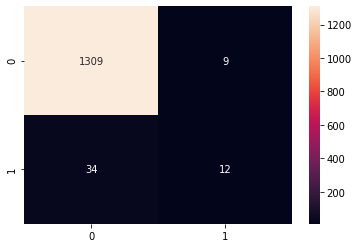

In [ ]:
model_1 = RandomForestClassifier(n_estimators=300)
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
print('accuracy is: ', accuracy_score(y_test, y_pred_1))
cm = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm, annot= True, fmt = 'd')

In [ ]:
arg_test = {'y_true' : y_test, 'y_pred':y_pred_1}
print(classification_report(**arg_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1318
           1       0.57      0.26      0.36        46

    accuracy                           0.97      1364
   macro avg       0.77      0.63      0.67      1364
weighted avg       0.96      0.97      0.96      1364



2. Logistic Regression classification

accuracy is:  0.966275659824047
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.97      0.95      1364



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


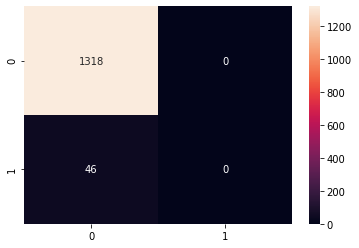

In [ ]:
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
print('accuracy is: ', accuracy_score(y_test, y_pred_2))
cm = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm, annot= True, fmt = 'd')
arg_test = {'y_true' : y_test, 'y_pred':y_pred_2}
print(classification_report(**arg_test))

3. Gradient Boost Classifier

accuracy is:  0.9721407624633431
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1318
           1       0.65      0.37      0.47        46

    accuracy                           0.97      1364
   macro avg       0.82      0.68      0.73      1364
weighted avg       0.97      0.97      0.97      1364



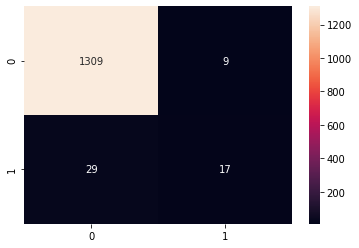

In [ ]:
model_3 = GradientBoostingClassifier(n_estimators=400,learning_rate=0.01)
model_3.fit(X_train, y_train)
y_pred_3 = model_3.predict(X_test)
print('accuracy is: ', accuracy_score(y_test, y_pred_3))
cm = confusion_matrix(y_test, y_pred_3)
sns.heatmap(cm, annot= True, fmt = 'd')
arg_test = {'y_true' : y_test, 'y_pred':y_pred_3}
print(classification_report(**arg_test))

4. Ada Boost classification

accuracy is:  0.969208211143695
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1318
           1       0.56      0.39      0.46        46

    accuracy                           0.97      1364
   macro avg       0.77      0.69      0.72      1364
weighted avg       0.96      0.97      0.97      1364



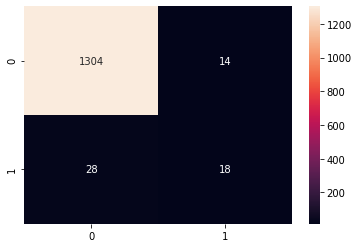

In [ ]:
model_4 = AdaBoostClassifier(n_estimators=200)
model_4.fit(X_train, y_train)
y_pred_4 = model_4.predict(X_test)
print('accuracy is: ', accuracy_score(y_test, y_pred_4))
cm = confusion_matrix(y_test, y_pred_4)
sns.heatmap(cm, annot= True, fmt = 'd')
arg_test = {'y_true' : y_test, 'y_pred':y_pred_4}
print(classification_report(**arg_test))

5. XGBoost classification

accuracy is:  0.9750733137829912
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1318
           1       0.73      0.41      0.53        46

    accuracy                           0.98      1364
   macro avg       0.86      0.70      0.76      1364
weighted avg       0.97      0.98      0.97      1364



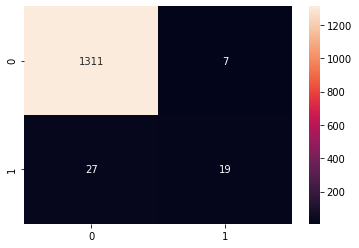

In [ ]:
model_5 = XGBClassifier(n_estimators=200,max_depth=5)
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
print('accuracy is: ', accuracy_score(y_test, y_pred_5))
cm = confusion_matrix(y_test, y_pred_5)
sns.heatmap(cm, annot= True, fmt = 'd')
arg_test = {'y_true' : y_test, 'y_pred':y_pred_5}
print(classification_report(**arg_test))

Cross Validation score on Recall score

In [ ]:
from sklearn.metrics import make_scorer, recall_score
recall_score = make_scorer(recall_score)
cv_score = cross_val_score(model_5,X_train,y_train,cv=5,scoring= recall_score)
print('cv_score: ',cv_score)
print('mean: ',cv_score.mean())

cv_score:  [0.17647059 0.25714286 0.28571429 0.2        0.25714286]
mean:  0.23529411764705882


In [ ]:
cv_score = cross_val_score(model_4,X_train,y_train,cv=5,scoring= recall_score)
print('cv_score: ',cv_score)
print('mean: ',cv_score.mean())

cv_score:  [0.29411765 0.31428571 0.25714286 0.31428571 0.31428571]
mean:  0.2988235294117647


### ROC Curve

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

Note that the ROC does not depend on the class distribution. This makes it useful for evaluating classifiers predicting rare events such as diseases or disasters. In contrast, evaluating performance using accuracy (TP +

TN)/(TP + TN + FN + FP) would favor classifiers that always predict a negative outcome for rare events.

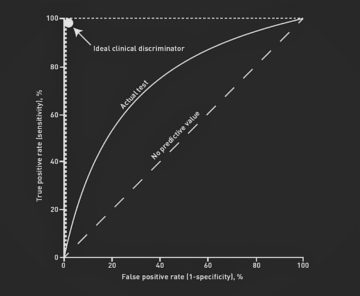

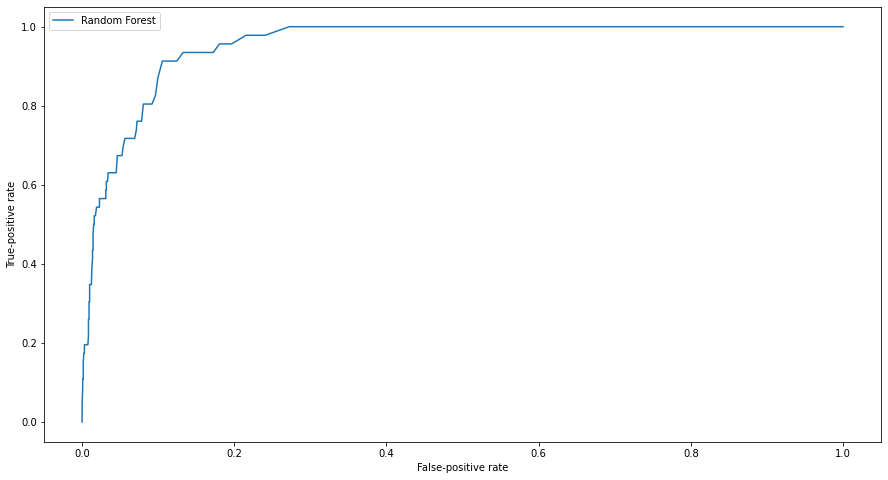

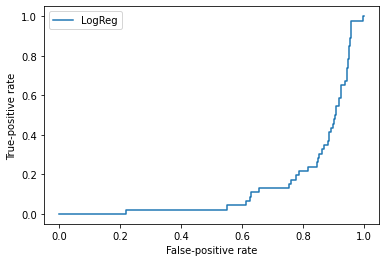

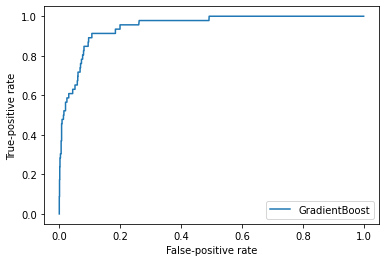

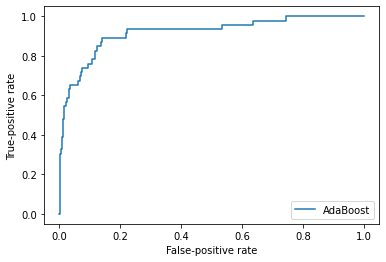

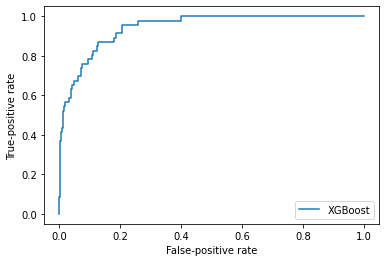

In [ ]:
models = dict()
models['Random Forest'] = RandomForestClassifier(n_estimators=300)
models['LogReg'] = LogisticRegression()
models['GradientBoost'] = GradientBoostingClassifier(n_estimators=400,learning_rate=0.01)
models['AdaBoost'] = AdaBoostClassifier(n_estimators=200)
models['XGBoost'] =  XGBClassifier(n_estimators=200,max_depth=5)

for model in models:
  models[model].fit(X_train, y_train)

from sklearn.metrics import roc_curve
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

for m in models:
  y_pred = models[m].predict_proba(X_test)
  fpr, tpr, _ = roc_curve(y_test, y_pred[:,1].ravel())
  plt.plot(fpr,tpr,label = m)
  plt.xlabel('False-positive rate')
  plt.ylabel('True-positive rate')
  plt.legend()
  plt.show()